In [1]:
using Pkg
# Pkg.activate("/media/mat/HDD/EnKF/")
Pkg.activate("/media/mat/HDD/VortexModels/")

Activating environment at `/media/mat/HDD/VortexModels/Project.toml`


In [2]:
using Revise
using EnKF
using Distributions
using DocStringExtensions
using RecursiveArrayTools

In [3]:
using PotentialFlow
import PotentialFlow.Utils: @get

┌ Info: Precompiling PotentialFlow [73af2aaf-3f58-5b29-82a9-435ecf827f5b]
└ @ Base loading.jl:1242
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for PotentialFlow [73af2aaf-3f58-5b29-82a9-435ecf827f5b]
│   exception = ErrorException("Required dependency FFTW [7a1cc6ca-52ef-59f5-83cd-3a7055c09341] failed to load from a cache file.")
└ @ Base loading.jl:1025
┌ Info: Recompiling stale cache file /home/mat/.julia/compiled/v1.2/FFTW/PvIn2.ji for FFTW [7a1cc6ca-52ef-59f5-83cd-3a7055c09341]
└ @ Base loading.jl:1240


In [4]:
using ProgressMeter
using LinearAlgebra
using Statistics
using ColorSchemes

In [5]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
clibrary(:colorbrewer)
pyplot()

┌ Info: Recompiling stale cache file /home/mat/.julia/compiled/v1.2/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /home/mat/.julia/compiled/v1.2/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1240


Plots.PyPlotBackend()

In [6]:
# if !Plots.is_installed("PyPlot")
#     Pkg.add("PyPlot")
# end
# withenv("PYTHON" => "") do
#     Pkg.build("PyPlot")
# end

## Load CFD Data

In [7]:
using FileIO
using Interpolations

In [8]:
# re500_data = load(expanduser("/home/matmat/Documents/PhD/VortexModel/DarwinVortex/data/re500_aoa20.jld2")) # No Pulse
# re500_data = load(expanduser("~/Documents/Research/data/rey500_pulse01_data.jld2"))
re500_data = load(expanduser("/media/mat/HDD/VortexModels/data/rey500_aoa20_2pulse01_data.jld2"))

Dict{String,Any} with 6 entries:
  "pressure"  => Dict{String,Any}("t"=>0.05:0.05:10.0,"edges"=>(-0.5, 0.5),"s"=…
  "Re"        => 500
  "aoa"       => 0.349066
  "force"     => Dict{String,Any}("t"=>0.001:0.001:10.0,"F"=>Complex{Float64}[-…
  "vorticity" => Dict{String,Any}("x"=>[-0.996, -0.992, -0.988, -0.984, -0.98, …
  "actuation" => ((3.0, 4.0), 0.01)

In [9]:
pressure_data = let pressure = -re500_data["pressure"]["p"],
    T = re500_data["pressure"]["t"],
    s = re500_data["pressure"]["s"],
    le = re500_data["pressure"]["edges"][1]
    
#     scale(interpolate(reverse(pressure, dims = 1), BSpline(Cubic(Line(OnGrid())))), 
#         reverse(sign(le)*s, dims = 1), T, extrapolation  = Flat())
    CubicSplineInterpolation((reverse(sign(le)*s), T),reverse(pressure, dims = 1), extrapolation_bc =  Line())
end;

In [10]:
function cfd_pressure(t, taps, config, pressure_data)
    s = [-0.5config.L*cos(n*π/(config.N-1)) for n in taps]
    [pressure_data(i,t) for i in s]
end

cfd_pressure (generic function with 1 method)

In [11]:
struct Config
    N::Int
    L::Float64
    ċ::ComplexF64
    α::Float64
    δ::Float64
    Δt::Float64
    transfer::Bool
end
config = let N = 512, L = 1.0, ċ = 1.0,
             α = π/9, δ = 5e-3, Δt = 1e-2

    Config(N, L, ċ, α, δ, Δt, true)
end

Config(512, 1.0, 1.0 + 0.0im, 0.3490658503988659, 0.005, 0.01, true)

In [12]:
tf = 5.0
pressure_taps = 10:10:config.N-10
T = 0:config.Δt:tf

0.0:0.01:5.0

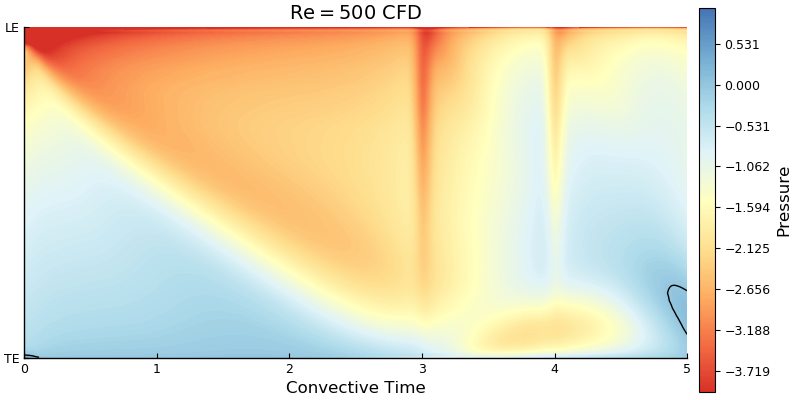

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.


In [13]:
sch = ColorSchemes.RdYlBu_9.colors
let s = [-0.5config.L*cos(θ) for θ in range(0.0, stop = π, length = config.N)][pressure_taps],
    #model_pressures = hcat((measure_state(mean(states[i+1]), t, config, pressure_taps) for (i,t) in enumerate(T))...),
    cfd_pressures = 2hcat((cfd_pressure(t, pressure_taps, config, pressure_data) for t in T)...)
        
    plt = plot(size = (800, 400))
    contourf!(T, s, cfd_pressures, title = ["\$\\mathrm{Re} = 500\$ CFD" "EnKF Mean"],
        levels = range(-4.0, stop = 1, length = 161), clims = (-4, 1), color = cgrad(sch), xlabel = "Convective Time",
        #levels = linspace(-2, 2, 151), clims = (-2, 0.5), color = cgrad(reverse(colormap(:rainbow))), xlabel = ["Convective Time"],
        yticks = ([0.5, -0.5], ["LE", "TE"]), background_color_inside = sch[1],colorbar_title="Pressure")
        #yticks = ([0.5, -0.5], ["LE", "TE"]), background_color_inside = colormap(:rainbow)[end], colorbar_title="Pressure")
    contour!(T, s, cfd_pressures,levels=0:0,seriescolor=:black)
end
# savefig("test1.pdf")
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/pressure_comparison.pdf")

## Model Formulation

We have a flat plate that is translating at a fixed angle of attack and velocity.
We also use a constant blob radius on all of our vortex elements

In [14]:
struct Config
    N::Int
    L::Float64
    ċ::ComplexF64
    α::Float64
    δ::Float64
    Δt::Float64
    transfer::Bool
end

In [15]:
include("/media/mat/HDD/VortexModels/SparseVortex/Jupyter notebooks/merging_model.jl")

regen_forces (generic function with 1 method)

#### Define measurement function m 

In [16]:
function (::MeasurementFunction)(t::Float64, s::TS) where TS
    return measure_state(s, t, config, pressure_taps)
end

In [17]:
m = MeasurementFunction()

MeasurementFunction()

#### Define real measurement function z

In [18]:
function (::RealMeasurementFunction)(t::Float64, ENS::EnsembleState{N, TZ}) where {N, TZ}
    
    real_meas = cfd_pressure(t, pressure_taps, config, pressure_data)
    
    fill!(ENS, real_meas)
    
    return ENS
end

In [19]:
z = RealMeasurementFunction()

RealMeasurementFunction()

#### Covariance inflation

In [20]:
β = 1.01

1.01

In [21]:
function (RI::RTPSRecipeInflation)(ENS::EnsembleState{N, TS}) where {N, TS}
    # unwrap parameters
    αp, αΓ, αlesp, αtesp, β, n = RI.p
    
    n = ceil(Int, n)
    
    # get size of a member
    NS = size(ENS.S[1])[1]
    
    Ŝ = mean(deepcopy(ENS))
     
    # Covariance inflation
    for (_,s) in enumerate(ENS.S)
        s .= Ŝ .+ β*(s .- Ŝ)
        # don't perturb the state at the 4 first time steps
        if n > 5
        for i in 1:3:size(Ŝ, 1)-3
            s[i:i+1] += αp*randn(2)
            s[i+2]   += αΓ*randn()
        end
            s[end-1] = s[end-1] + αlesp*randn()
            s[end] = s[end] + αtesp*randn()
        end
    end
    
    return ENS
end

In [22]:
function (RI::RecipeInflation)(ENS::EnsembleState{N, TS}) where {N, TS}
    # unwrap parameters
    αp, αΓ, αlesp, αtesp, β, n = RI.p
    
    n = ceil(Int, n)
    
    # get size of a member
    NS = size(ENS.S[1])[1]
    
    Ŝ = mean(deepcopy(ENS))
     
    # Covariance inflation
    for (_,s) in enumerate(ENS.S)
        s .= Ŝ .+ β*(s .- Ŝ)
        # don't perturb the state at the 4 first time steps
        if n > 5
        for i in 1:3:size(Ŝ, 1)-3
            s[i:i+1] += αp*randn(2)
            s[i+2]   += αΓ*randn()
        end
            s[end-1] = s[end-1] + αlesp*randn()
            s[end] = s[end] + αtesp*randn()
        end
    end
    
    return ENS
end

#### Define state filtering

In [23]:
function (::FilteringFunction)(ENS::EnsembleState{N, TS}) where {N, TS}
    
    for s in ENS.S
        clamp(s[end-1],0.0,3.0)
    end
    return ENS
end

In [24]:
g = FilteringFunction()

FilteringFunction()

#### Define propagation function f with merging

In [25]:
function (::PropagationFunction)(t::Float64, ENS::EnsembleState{N, TS}) where {N, TS}
    
    states = deepcopy([ENS.S])
    
    
    push!(states, [])
    empty_inds = Vector{Int}[]
    len = Int[]
    
    # predicted_states (with merging)
    for (i, state) in enumerate(states[end-1])
        new_state = state_equation(state, t, config)
        new_blobs, lesp, tesp = state_to_blobs(new_state, config.δ)
        push!(empty_inds, findall(b -> circulation(b) == 0, new_blobs))
        push!(len, length(new_blobs))
        push!(states[end], new_state)
    end
    
    # trim zeros
    @assert all(len .== len[1])
    toremove = intersect(empty_inds...)
    tokeep = filter(i -> i ∉ toremove, 1:len[1])
    for (i, state) in enumerate(states[end])
        new_blobs, lesp, tesp = state_to_blobs(state, config.δ)
        states[end][i] = blobs_to_state(new_blobs[tokeep], lesp, tesp)
    end
    
    # Wrap into an EnsembleState variable
    ENS.S = deepcopy(states[end])
 
    return ENS
end

In [26]:
fprop = PropagationFunction()

PropagationFunction()

#### Initialize config

In [27]:
config = let N = 512, L = 1.0, ċ = 1.0,
             α = π/9, δ = 5e-3, Δt = 1e-2

    Config(N, L, ċ, α, δ, Δt, true)
end

Config(512, 1.0, 1.0 + 0.0im, 0.3490658503988659, 0.005, 0.01, true)

In [28]:
N = 1 #50
NZ = 50
isenkf = true
isinflated = true
isfiltered = true
isaugmented = true

true

#### Define noise filtering

In [29]:
ϵ = AdditiveInflation(MvNormal(zeros(NZ), 1.0*10^-4*I));

#### Distribution perturbation initial state

In [36]:
# lesp₀ = 0.5 #0.5
# tesp₀ = 0.0
# lesprand = 0.0#0.1
# # Distx₀ = TupleProduct((TruncatedNormal(lesp₀, lesprand, 0.0, 3.0),
# #             Normal(tesp₀, 0.0)))
# Distx₀ = TupleProduct((Normal(lesp₀, lesprand),
#             Normal(tesp₀, 0.0)))
# ens = initialize(N, Distx₀)

# system = [deepcopy(ens.S)]#[map((a,b) -> [a, b], lesps, tesps)];

# covs = [];

# # lesp₀ = 0.5 #0.5
# # tesp₀ = 0.0
# # lesprand = 0.0 #0.1
# # lesps = clamp.(lesp₀ .+ lesprand*randn(N), 0.0, 3.0);
# # tesps = tesp₀ .+ 0.0randn(N);

# # states = [map((a,b) -> [a, b], lesps, tesps)]

# # ens = EnsembleState(deepcopy(states[1]))
# # states = [deepcopy(ens.S)] 

# lesp₀ = 0.5 #0.5
# tesp₀ = 0.0
# lesprand = 0.0 #0.1
# lesps = clamp.(lesp₀ .+ lesprand*randn(N), 0.0, 3.0);
# tesps = tesp₀ .+ 0.0randn(N);

# states = [map((a,b) -> [a, b], lesps, tesps)]

1-element Array{Array{Array{Float64,1},1},1}:
 [[0.5, 0.0]]

In [37]:
ri = RecipeInflation([1e-5,1e-5, 5e-5,0.0, β, 0])
# ri = RTPSRecipeInflation(1.0, [1e-5,1e-5, 5e-5,0.0, β, 0])
# ri = RTPSInflation(0.2)

RecipeInflation(Real[1.0e-5, 1.0e-5, 5.0e-5, 0.0, 1.01, 0.0])

In [38]:
# enkf = ENKF(N, NZ, fprop, ri, g, m, z, ϵ; isenkf = false, isinflated = isinflated, isfiltered = isfiltered,
#     isaugmented = isaugmented);
# enkf = ENKF(N, NZ, fprop, ri, g, m, z, ϵ; isenkf = false, isinflated = isinflated, isfiltered = isfiltered,
#     isaugmented = isaugmented);

In [39]:
tf = 60*config.Δt
pressure_taps = 10:10:config.N-10
T = 0:config.Δt:tf

t = 0.0
@showprogress for (n,ti) in enumerate(T)
    
#     push!(states, [])
#     empty_inds = Vector{Int}[]
#     len = Int[]
    
#     # predicted_states (with merging)
#     for (i, state) in enumerate(states[end-1])
#         new_state = state_equation(state, t, config)
#         new_blobs, lesp, tesp = state_to_blobs(new_state, config.δ)
#         push!(empty_inds, findall(b -> circulation(b) == 0, new_blobs))
#         push!(len, length(new_blobs))
#         push!(states[end], new_state)
#     end
    
#     # trim zeros
#     @assert all(len .== len[1])
#     toremove = intersect(empty_inds...)
#     tokeep = filter(i -> i ∉ toremove, 1:len[1])
#     for (i, state) in enumerate(states[end])
#         new_blobs, lesp, tesp = state_to_blobs(state, config.δ)
#         states[end][i] = blobs_to_state(new_blobs[tokeep], lesp, tesp)
#     end
    
    # Wrap into an EnsembleState variable
#     ENS.S = deepcopy(states[end])
 
#     return ENS
    
    enkf.f(ti, ens)
#     fprop(ti, ens)
#     @show ens.S
#     global t, ens = enkf(t, config.Δt, ens)
#     @show ti
#     @show ti
#     @show enkf.m(ti, ens.S[1])
#     print(t)
    push!(system, deepcopy(ens.S))
#     push!(covs, P̂)

end

# @showprogress for (n,ti) in enumerate(T)
#     ri.p[6] = deepcopy(n)
#     global t, ens
#     t, ens, cov = enkf(t, config.Δt, ens)
# #     print(t)
#     push!(states, deepcopy(ens.S))
#     push!(covs, cov)

# end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [40]:
states[40]

1-element Array{Array{Float64,1},1}:
 [0.6781346755873348, 0.1960893718670128, 0.14969103427689423, -0.3908689343133717, -0.1661373240844032, -0.324472169965975, -0.15810909263701672, -0.19468630160317077, -0.006184174789501239, -0.34401812476847105  …  -0.18231458925618205, -0.0053191448665830185, 0.8397923437423936, 0.18718702632863476, 0.014952825234014387, -0.098572515413195, -0.1785846818480516, -0.005126363391084707, 0.5, 0.0]

In [331]:
states[40]

1-element Array{Array{Float64,1},1}:
 [0.6781346755873356, 0.19608937186701308, 0.14969103427689423, -0.3908689343133717, -0.16613732408440307, -0.32447216996597505, -0.1581090926370165, -0.19468630160317077, -0.006184174789501239, -0.34401812476847116  …  -0.18231458925618202, -0.005319144866583031, 0.8397923437423936, 0.18718702632863476, 0.014952825234014339, -0.098572515413195, -0.1785846818480516, -0.0051263633910847185, 0.5, 0.0]

In [150]:
system[end][1]

179-element Array{Float64,1}:
  3.716893166971964   
  1.6138650211324035  
  0.5202206982095818  
  0.24288292220380656 
 -0.3728151154563427  
 -0.5855565459992196  
  0.4626589605056572  
 -0.584149324186126   
 -0.29354412045122114 
  4.21426204510983    
  2.0445071598023232  
  0.12219468819858656 
  4.5655829821533445  
  ⋮                   
  0.00975002539627939 
 14.518775122698445   
 -0.1826079972527546  
 -0.011823912103587339
 15.461435669753232   
  0.18738272667109976 
  0.010017146102135253
 14.525990109853987   
 -0.17911968975229972 
 -0.009620514873451128
  0.5                 
  0.0                 

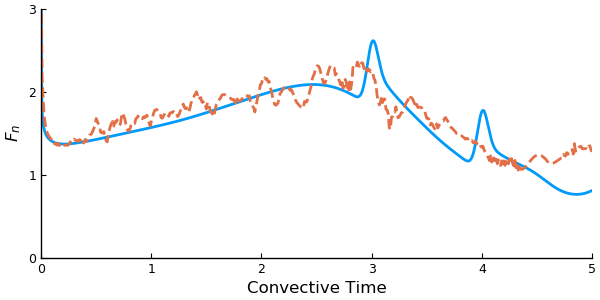

In [90]:
fn = regen_forces(T, mean.(system), config);
plot(re500_data["force"]["t"], abs.(re500_data["force"]["F"]), label = "\$\\mathrm{Re} = 500\$ CFD", xlim = (0,5),
legend = false, linewidth = 2)
plot!(T, 2abs.(fn)[1:end-1], ylim = (0, 3), label = "EnKF Mean", ylabel="\$F_n\$", xlabel = "Convective Time", size = (600, 300),
linewidth = 2, linestyle = :dash)
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/force.pdf")

In [52]:
phist = [measure_state(mean(si), T[i], config, pressure_taps) for (i,si) in enumerate(states[2:end])]
phist = convert(Array, VectorOfArray(phist))

pmeas = convert(Array, VectorOfArray([cfd_pressure(ti, pressure_taps, config, pressure_data) for ti in T]));

Δp = phist - pmeas;

UndefVarError: UndefVarError: states not defined

┌ Warning: scale log is unsupported with Plots.PyPlotBackend().  Choose from: Symbol[:identity, :ln, :log2, :log10]
└ @ Plots /home/mat/.julia/packages/Plots/l0VjU/src/args.jl:1176
┌ Warning: scale log is unsupported with Plots.PyPlotBackend().  Choose from: Symbol[:identity, :ln, :log2, :log10]
└ @ Plots /home/mat/.julia/packages/Plots/l0VjU/src/args.jl:1176
┌ Warning: scale log is unsupported with Plots.PyPlotBackend().  Choose from: Symbol[:identity, :ln, :log2, :log10]
└ @ Plots /home/mat/.julia/packages/Plots/l0VjU/src/args.jl:1176
┌ Warning: scale log is unsupported with Plots.PyPlotBackend().  Choose from: Symbol[:identity, :ln, :log2, :log10]
└ @ Plots /home/mat/.julia/packages/Plots/l0VjU/src/args.jl:1176
┌ Warning: scale log is unsupported with Plots.PyPlotBackend().  Choose from: Symbol[:identity, :ln, :log2, :log10]
└ @ Plots /home/mat/.julia/packages/Plots/l0VjU/src/args.jl:1176
┌ Warning: scale log is unsupported with Plots.PyPlotBackend().  Choose from: Symbol[:identity,

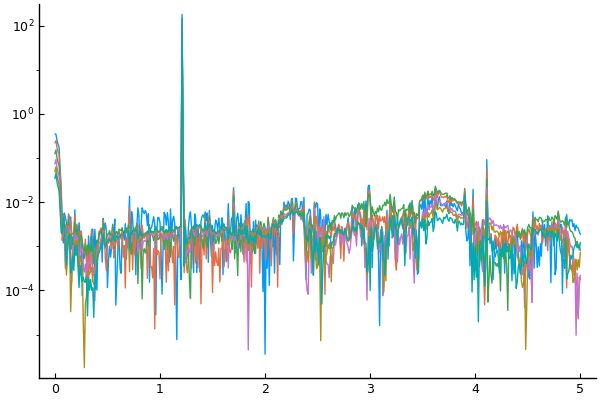

In [108]:
plt = plot(legend =false)
for i = 1:6
plot!(T, norm.(Δp[i,:])./norm(pmeas[i,:]), yscale = :log)
end
plt

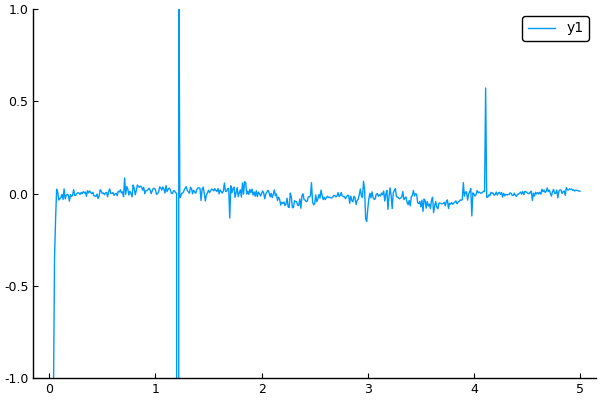

In [111]:
plot(T, Δp[1,:], ylim = (-1, 1))

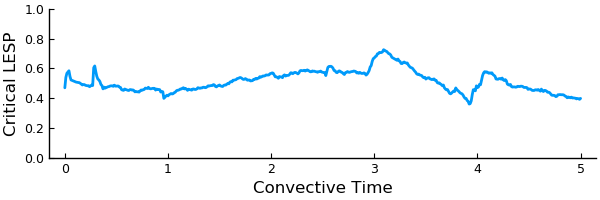

In [42]:
plot(T, [mean((x -> x[end-1]).(s)) for s in states[2:end]], legend = false,
    xlabel = "Convective Time", ylabel = "Critical LESP", linewidth = 2, size = (600, 200),
ylim = (0, 1))
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/lesp.pdf")

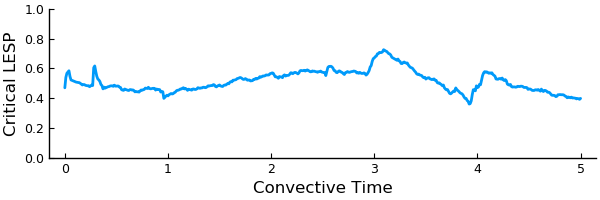

In [43]:
plot(T, [mean((x -> x[end-1]).(s)) for s in states[2:end]], legend = false,
    xlabel = "Convective Time", ylabel = "Critical LESP", linewidth = 2, size = (600, 200),
ylim = (0, 1))
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/lesp.pdf")

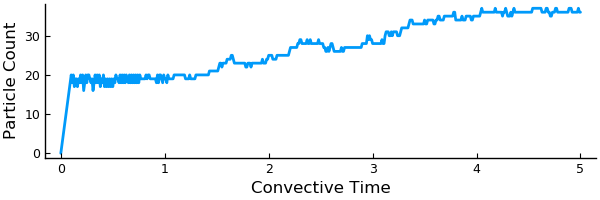

In [44]:
plot(T, [(length(s[1]) - 2) ÷ 3 for s in states[1:end-1]], linewidth = 2, size = (600, 200), legend = false,
xlabel = "Convective Time", ylabel="Particle Count")
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/particle_count.pdf")

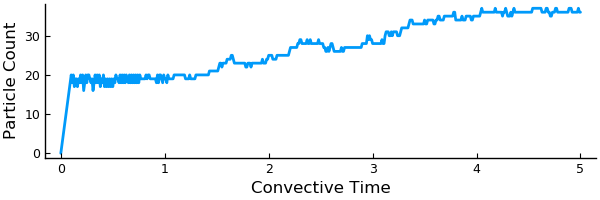

In [45]:
plot(T, [(length(s[1]) - 2) ÷ 3 for s in states[1:end-1]], linewidth = 2, size = (600, 200), legend = false,
xlabel = "Convective Time", ylabel="Particle Count")
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/particle_count.pdf")

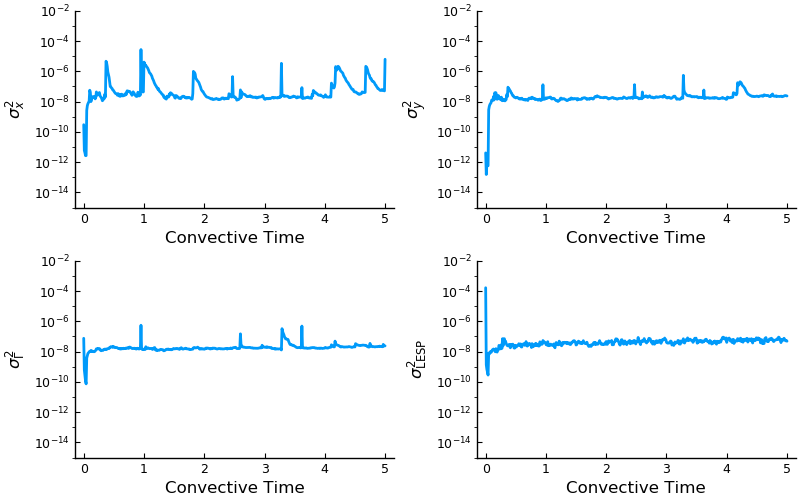

In [46]:
plt = plot(layout = (2,2), size = (800, 500), legend = false)
plot!(plt[1], T, map(covs) do P
        mean(diag(P)[1:3:end-3]) + eps()
        end, ylim = (1e-15, 1e-2), yscale = :log10, linewidth = 2, xlabel = "Convective Time",
ylabel = "\$\\sigma_x^2\$")
plot!(plt[2], T, map(covs) do P
        mean(diag(P)[2:3:end-3]) + eps()
        end, ylim = (1e-15, 1e-2), yscale = :log10, linewidth = 2, xlabel = "Convective Time",
ylabel = "\$\\sigma_y^2\$")
plot!(plt[3],T,  map(covs) do P
        mean(diag(P)[3:3:end-3]) + eps()
        end, ylim = (1e-15, 1e-2), yscale = :log10, linewidth = 2, xlabel = "Convective Time",
ylabel = "\$\\sigma_\\Gamma^2\$")
plot!(plt[4], T, map(covs) do P
        mean(diag(P)[end-1]) + eps()
        end, ylim = (1e-15, 1e-2), yscale = :log10, linewidth = 2, xlabel = "Convective Time",
ylabel = "\$\\sigma_\\mathrm{LESP}^2\$")
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/covariance.pdf")

### Snapshot Figures

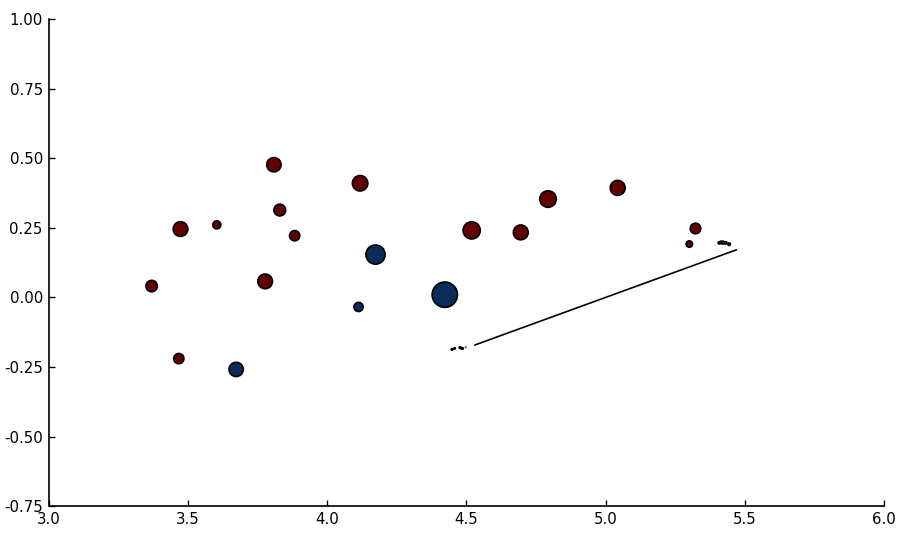

In [47]:
n = 500
# for n in [250, 300, 350, 400, 450, 500]
plt = plot(colorbar = :none, size = (750, 450), dpi = 120)
plot!(plt, Plate(config.N, config.L, config.Δt*n, config.α), ratio = 1, legend = false)
plot!(plt, state_to_blobs(mean(states[n]), config.δ)[1], markersize = 15sqrt.(abs.(mean(states[n])[3:3:end-2])), markerstrokealpha = 0, color = cgrad(reverse(colormap("RdBu"))), clim = (-0.02, 0.02), 
    ratio = 1, xlim = (n/100 - 2, n/100 + 1), ylim = (-0.75,1), xticks = (n/100 - 2):0.5:(n/100 + 1)
)
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/enkf_t$(lpad(n, 3, 0)).pdf")

# plt = plot(colorbar = :none, size = (750, 450), dpi = 120)
# contour!(plt, n/100 - re500_data["vorticity"]["x"], re500_data["vorticity"]["y"],
#     transpose(re500_data["vorticity"]["vorticity"][n÷5]), levels = linspace(-30, 30, 100),
#     color = :RdBu, clim = (-20, 20),
#     xlim = (n/100 - 2, n/100 + 1), ylim = (-0.75, 1), ratio = 1, legend = :none, xticks = (n/100 - 2):0.5:(n/100 + 1))
# savefig("EnKF\ Results/Re500/2pulse01/multiplicative_inflation/cfd_t$(lpad(n, 3, 0)).pdf")
# end

In [48]:
typeof(reverse(colormap("RdBu")))

Array{RGB{Float64},1}

In [49]:
ColorSchemes.RdBu_9)

LoadError: syntax: extra token ")" after end of expression

In [50]:
cgrad(ColorSchemes.RdBu_9)

MethodError: MethodError: no method matching cgrad_colors(::ColorScheme)
Closest candidates are:
  cgrad_colors(!Matched::Array{RGBA{Float64},1}) at /home/mat/.julia/packages/PlotUtils/35TGG/src/color_gradients.jl:173
  cgrad_colors(!Matched::ColorGradient) at /home/mat/.julia/packages/PlotUtils/35TGG/src/color_gradients.jl:172
  cgrad_colors(!Matched::Symbol; color_library) at /home/mat/.julia/packages/PlotUtils/35TGG/src/color_gradients.jl:164
  ...

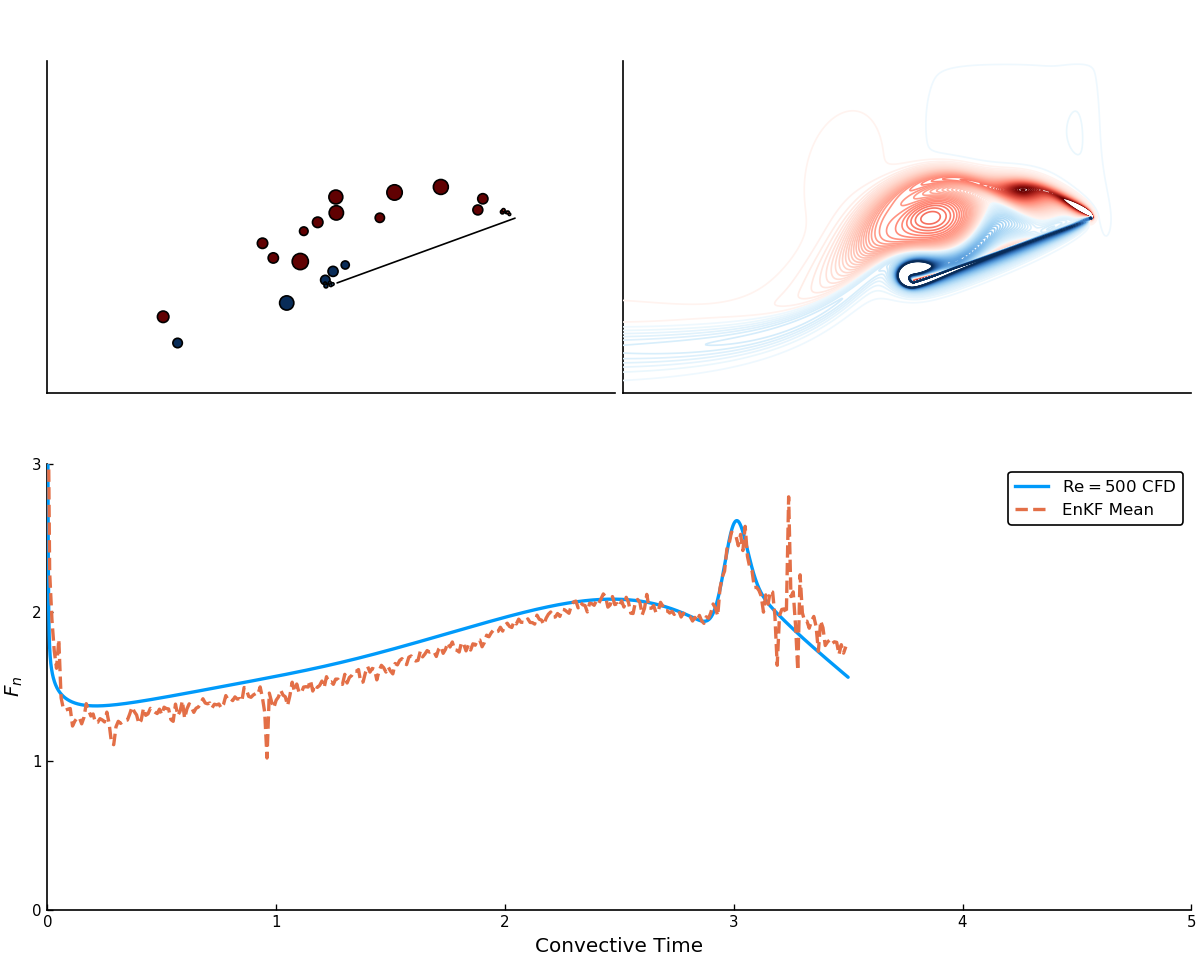

findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.


In [51]:
f = regen_forces(T, mean.(states), config);
n = 350
# @showprogress for (i,n) in enumerate(5:5:500)
l = @layout [  grid(1, 2)
               b{0.5h} ]

plt = plot(layout = l, colorbar = :none, size = (1000, 800), dpi = 120)
plot!(plt[1], Plate(config.N, config.L, config.Δt*n, config.α), ratio = 1, legend = false)
plot!(plt[1], state_to_blobs(mean(states[n]), config.δ)[1], markersize = 15sqrt.(abs.(mean(states[n])[3:3:end-2])), markerstrokealpha = 0, color = cgrad(reverse(colormap("RdBu"))), clim = (-0.02, 0.02), 
    ratio = 1, xlim = (n/100 - 2, n/100 + 1), ylim = (-0.75,1),
    xticks = [], yticks = [])
    contour!(plt[2], re500_data["vorticity"]["x"], re500_data["vorticity"]["y"],
    reverse(transpose(re500_data["vorticity"]["vorticity"][n÷5 + 1]), dims = 2), levels = range(-20.0, stop = 20.0, length = 100),
    color = cgrad((colormap("RdBu"))), clim = (-20, 20),
    xlim = (1.5, 4.5), ylim = (-0.75, 1), ratio = 1, legend = :none, xticks = [], yticks = []
)   
plot!(plt[3], re500_data["force"]["t"][1:10n], abs.(re500_data["force"]["F"][1:10n]), linewidth = 2, label = "\$\\mathrm{Re} = 500\$ CFD")
plot!(plt[3], T[1:n], 2abs.(f)[1:n], label = "EnKF Mean", linewidth = 2, linestyle = :dash, ylabel="\$F_n\$", xlabel = "Convective Time", xlim = (0, 5), ylim = (0, 3))
# plot!(plt[3], T[1:n], abs.(re500_data["force"]["F"])[1:n], label = "EnKF Mean", linewidth = 2, linestyle = :dash, ylabel="\$F_n\$", xlabel = "Convective Time", xlim = (0, 5), ylim = (0, 3))

# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/state_$(lpad(i,3,0)).png")
# end

In [52]:
# # for n in [3, 4, 6, 8]
# n = 3
# let s = [-0.5config.L*cos(θ) for θ in range(0.0, stop = π, length = config.N)][pressure_taps],
#     model_pressures = hcat((measure_state(states[i+1][n], t, config, pressure_taps) for (i,t) in enumerate(T[1:300]))...),
# #     cfd_pressures = hcat((cfd_pressure(t, pressure_taps, config, pressure_data) for t in T)...)
    
#     plt = plot(size = (800, 200))
#     contourf!(T[1:300], s, model_pressures,
#         levels = range(-2.0, stop = 2.0, length = 151), clims = (-2, 2), color = cgrad(reverse(colormap("RdBu"))), xlabel = ["" "Convective Time"],
#         yticks = ([0.5, -0.5], ["LE", "TE"]), background_color_inside = colormap("RdBu")[end], colorbar_title="Pressure")
# end
# savefig("EnKF\ Results/Ensemble/pressure_n$(lpad(n,2,0)).pdf")
# # end

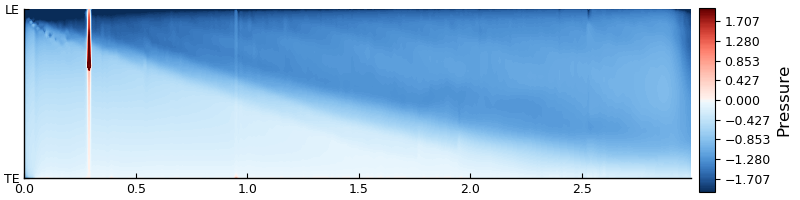

In [53]:
let s = [-0.5config.L*cos(θ) for θ in range(0.0, stop = π, length = config.N)][pressure_taps],
    model_pressures = hcat((measure_state(states[i+1][1], t, config, pressure_taps) for (i,t) in enumerate(T[1:300]))...),
#     cfd_pressures = hcat((cfd_pressure(t, pressure_taps, config, pressure_data) for t in T)...)
    
    plt = plot(size = (800, 200))
    contourf!(T[1:300], s, model_pressures,
        levels = range(-2.0, stop = 2.0, length = 151), clims = (-2, 2), color = cgrad(reverse(colormap("RdBu"))), xlabel = ["" "Convective Time"],
        yticks = ([0.5, -0.5], ["LE", "TE"]), background_color_inside = colormap("RdBu")[end], colorbar_title="Pressure")
end
#savefig("EnKF\ Results/Ensemble/pressure_n$(lpad(n,2,0)).pdf")